---
Concept Relevance Propagation (CRP) Evaluation Sensitivity 
---


**Description:**  
Performs Quanlitative analysis on local scale (sensitivity analysis)
### Additional Comments
### Author: Viswambhar Yasa

### Date: 09-01-2024

**Contact Information:**  
Email: [yasa.viswambhar@gmail.com](mailto:yasa.viswambhar@gmail.com)

In [1]:
import gc
import os
import sys
import torch
import quantus
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from zennit.attribution import Gradient
from captum.attr import IntegratedGradients,GradientShap,Occlusion

d:\finaldraft\ExplainingWilderness\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
notebook_directory = Path().resolve().parent
sys.path.insert(0,str(notebook_directory.parent))

from experiment.helper_functions import load_dict
from sentinelmodels.pretrained_models import buildmodel
from interpret.concept.conceptpropagation import get_composite
from interpret.concept.conceptrelevance import ConceptRelevance

In [15]:
config={    
                "root_dir":r'D:/master-thesis/Dataset/anthroprotect',
                "datasplitfilename": r"infos.csv",
                "n_classes":2,
                "datasaved":True,
                "device":"cpu",
                "models":["alexnet","vgg16","resnet18"],
                "modelweightpaths":[r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/alexnet_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/vgg16_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/resnet18_best_model.pth",
                                    ],
                "cmap":"hot",
                "plotmethod":"heat_map"
                }

datafilepath=r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/data/localevalution_datasample.pkl"
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/heatmaps/"
modelindex=-1
imagename=config["models"][modelindex]

loaded_data = dictionary = load_dict(datafilepath)

images = loaded_data["images"].to(config["device"])
labels = loaded_data["labels"]


In [16]:
print(len(labels[labels==1]))

tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 0])


In [18]:
model=buildmodel(model_type=config["models"][modelindex],multiclass_channels=config["n_classes"],modelweightpath=config["modelweightpaths"][modelindex]).to(config["device"])

In [19]:
def generate_explaination(model,inputs,targets,abs=False, normalise=False, *args,**kwargs):
    """ wrapper over captium xai methods based on the tutorials from quantus
    """
    gc.collect()
    torch.cuda.empty_cache()
    # Set model in evaluate mode.

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = torch.Tensor(inputs).to(kwargs.get("device", None))
    xaimethod=kwargs.get("method", "IntegratedGradients")
    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size) e.g., (1, 3, 224, 224)."
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))
    baselines = torch.zeros_like(inputs).to(kwargs.get("device", None))
    #print("Running: ",xaimethod)
    if xaimethod=="IntergratedGradients":
        heatmaps = IntegratedGradients(model).attribute(inputs=inputs, target=targets,
                                                                    baselines=baselines,n_steps=10,
                                                                    method="riemann_trapezoid").sum(axis=1).reshape(-1, kwargs.get("img_size", 256), kwargs.get("img_size", 256)).cpu().data
    elif xaimethod=="GradientShap":
        heatmaps = GradientShap(model).attribute(inputs=inputs, target=targets,
                                                            baselines=baselines,n_samples=10).sum(axis=1).reshape(-1, kwargs.get("img_size", 256), kwargs.get("img_size", 256)).cpu().data
    elif xaimethod=="Occlusion":
        heatmaps = Occlusion(model).attribute(inputs=inputs, target=targets, strides=kwargs.get("strides",(3,25,25)), sliding_window_shapes=kwargs.get("sliding_window_shapes",(3,50,50))).sum(axis=1).reshape(-1, kwargs.get("img_size", 256), kwargs.get("img_size", 256)).cpu().data
    elif xaimethod=="LRP":
        targets = torch.nn.functional.one_hot(targets, num_classes=kwargs.get("n_classes", 2)).long().to(kwargs.get("device", None))
        composite=get_composite(kwargs.get("lrpcompositetype","epsilon"),kwargs.get("modeltype", "resnet18"))
        with Gradient(model=model, composite=composite) as attributor:
            out, relevance = attributor(inputs, targets)
        heatmaps =relevance.sum(axis=1).reshape(-1, kwargs.get("img_size", 256), kwargs.get("img_size", 256)).cpu().data
    elif xaimethod=="CRP":

        Concepts=ConceptRelevance(model,device=kwargs.get("device", None))
        condition=[{"y":[0]},{"y":[1]}]
        relevance,_,_=Concepts.conditional_relevance(inputs,condition=condition,compositename=kwargs.get("crpcompositetype","epsilon"),canonizerstype=kwargs.get("modeltype", "resnet18"),output_type="max",record_layer=list(Concepts.layer_map.keys()))
        reshaped_tensor = relevance.view(int(relevance.shape[0]/2), 2, relevance.shape[-2], relevance.shape[-1])
        heatmaps =reshaped_tensor.sum(axis=1).reshape(-1, kwargs.get("img_size", 256), kwargs.get("img_size", 256)).cpu().data
    if normalise:
            heatmaps = quantus.normalise_func.normalise_by_negative(heatmaps)
    gc.collect()
    torch.cuda.empty_cache()
    if isinstance(heatmaps, torch.Tensor):
        if heatmaps.requires_grad:
            return heatmaps.cpu().detach().numpy()
        return heatmaps.cpu().numpy()
    return heatmaps

In [ ]:
results = {xaimethod: quantus.MPRT(
    layer_order="independent",
    #layer_order="top_down",
    similarity_func=quantus.similarity_func.correlation_spearman,
    normalise=True,
)(model=model, 
   x_batch=images.detach().cpu().numpy(),
   y_batch=labels.detach().cpu().numpy(),
   a_batch=None,
   explain_func=generate_explaination, 
   explain_func_kwargs={"method": xaimethod,"compositetype":"epsilonplus","modeltype":config["models"][modelindex],"device": torch.device(config["device"])} ,
   device=torch.device(config["device"])) for xaimethod in ["IntergratedGradients", "GradientShap","LRP","CRP","Occlusion"]}


In [ ]:
from quantus.helpers.plotting import plot_model_parameter_randomisation_experiment

plot_model_parameter_randomisation_experiment(results=results, methods=["IntergratedGradients", "GradientShap","LRP","CRP","Occlusion"], similarity_metric=quantus.similarity_func.correlation_spearman.__name__.replace("_", "").capitalize())

In [ ]:
index=[0,1,4,8,11,2,3,12]
print(labels[index])

In [20]:
results = {xaimethod: quantus.PixelFlipping(
    features_in_step=256,
    perturb_baseline="black",
    perturb_func=quantus.perturb_func.baseline_replacement_by_indices,
    display_progressbar=True)
    (model=model, 
   x_batch=images[index,:,:,:].detach().cpu().numpy(),
   y_batch=labels[index].detach().cpu().numpy(),
   a_batch=None,
   explain_func=generate_explaination, 
   explain_func_kwargs={"method": xaimethod,"lrpcompositetype":"epsilon","crpcompositetype":"epsilonplus","modeltype":config["models"][modelindex],"device": torch.device(config["device"])} ,
   device=torch.device(config["device"])) for xaimethod in ["IntergratedGradients", "GradientShap","LRP","CRP","Occlusion"]}


  0%|          | 0/1.0 [17:37<?, ?it/s]
8it [14:52, 111.52s/it]
8it [14:21, 107.69s/it]                
8it [12:42, 95.30s/it]                 
8it [12:59, 97.40s/it]                 
8it [16:31, 123.98s/it]                


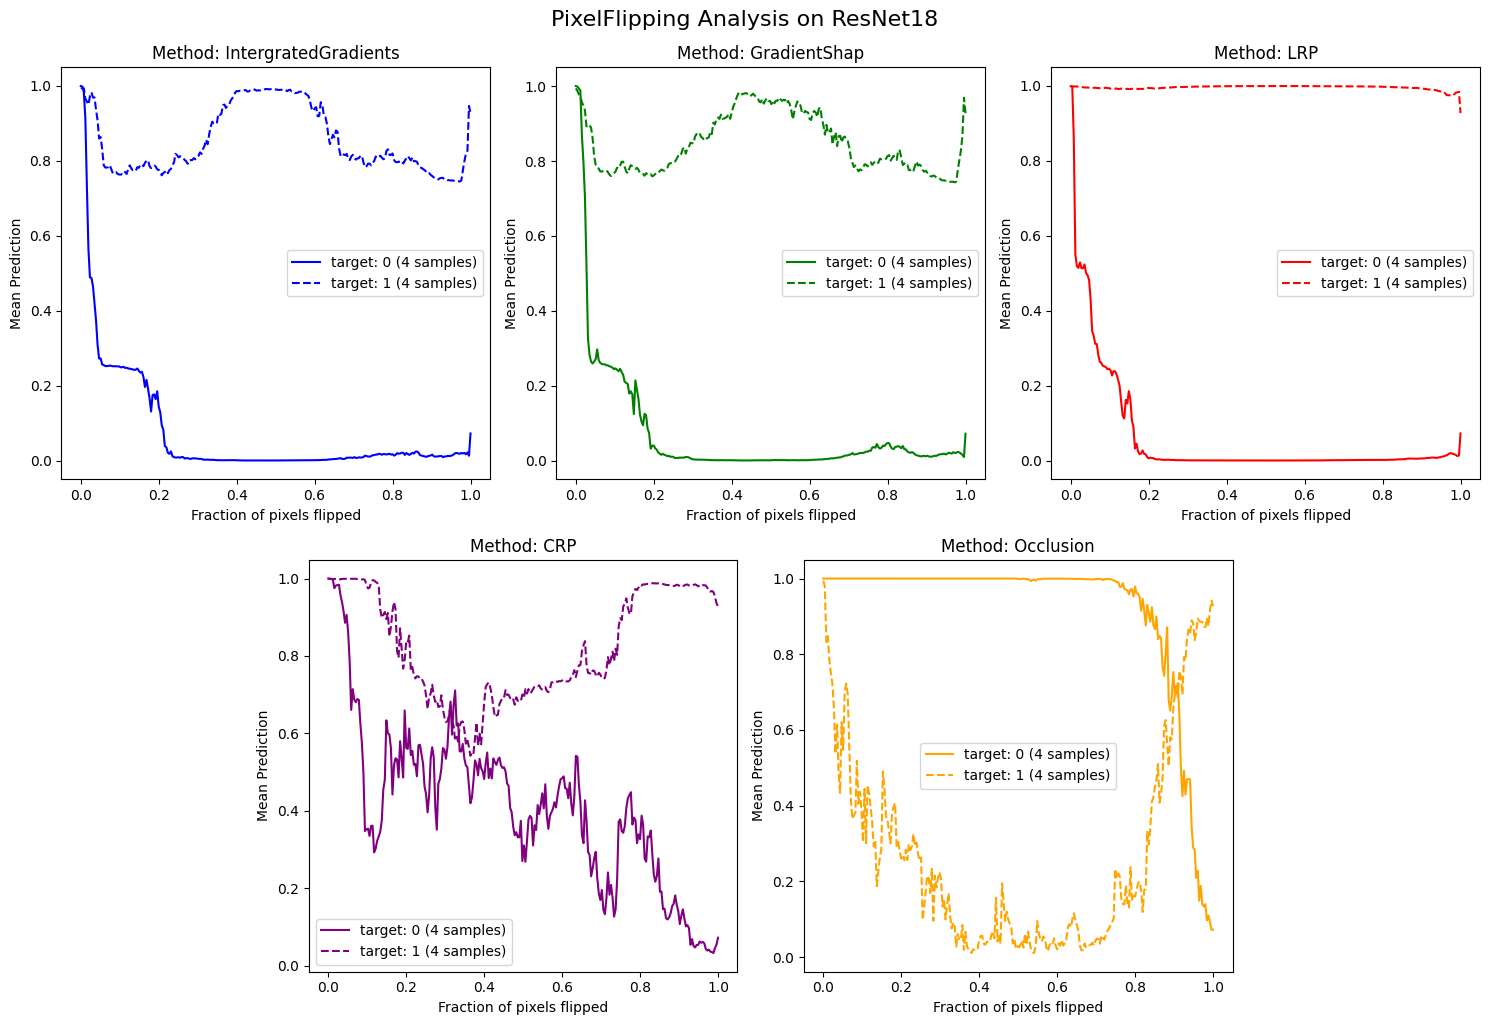

In [21]:
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Create a figure
fig = plt.figure(figsize=(15, 10))

# Define the grid layout
gs = gridspec.GridSpec(2, 6)

# Assign subplot positions using GridSpec
subplot_positions = [gs[0, :2], gs[0, 2:4], gs[0, 4:], gs[1, 1:3], gs[1, 3:5]]
### optimized the pixel flipping plot function from quantus to run for a dict
for i, (key, value) in enumerate(results.items()):
    ax = fig.add_subplot(subplot_positions[i])
    color = colors[i % len(colors)]

    for c in np.unique(labels[index]):
        indices = np.where(labels[index] == c)
        line_style = '-' if c % 2 == 0 else '--'

        # Plot the data
        ax.plot(
            np.linspace(0, 1, len(value[0])),
            np.mean(np.array(value)[indices], axis=0),
            color=color,
            linestyle=line_style,
            label=f"target: {str(c)} ({indices[0].size} samples)"
        )

    # Add legend and title to each subplot
    ax.legend()
    ax.set_title(f"Method: {key}")
    ax.set_xlabel("Fraction of pixels flipped")
    ax.set_ylabel("Mean Prediction")

# Adjust layout to avoid overlap
plt.tight_layout()
plt.suptitle("PixelFlipping Analysis on ResNet18",fontsize=16, x=0.5, y=1.02, va='top')
plt.show()
